## Imports

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
%tensorflow_version 2.x
import tensorflow as tf
from tensorflow import keras

In [ ]:
from keras.models import Sequential, Model
from keras.layers import Flatten, Dense, LSTM, GRU, SimpleRNN, RepeatVector, Input
from keras import backend as K
from keras.utils.vis_utils import plot_model
import keras.regularizers
import keras.optimizers

## Load data

In [ ]:
!git clone https://github.com/luisferuam/DLFBT-LAB

Cloning into 'DLFBT-LAB'...
remote: Enumerating objects: 82, done.
remote: Counting objects: 100% (82/82), done.
remote: Compressing objects: 100% (59/59), done.
remote: Total 82 (delta 43), reused 57 (delta 21), pack-reused 0
Unpacking objects: 100% (82/82), done.


In [ ]:
f = open('DLFBT-LAB/data/el_quijote.txt', 'r')
quijote = f.read()
f.close()
print(len(quijote))

1038397


## Input/output sequences

In [ ]:
quijote_x = quijote[:-1]
quijote_y = quijote[1:]

## Some utility functions

In [ ]:
def one_hot_encoding(data):
  symbols = np.unique(data)
  
  char_to_ix = {s: i for i, s in enumerate(symbols)}
  ix_to_char = {i: s for i, s in enumerate(symbols)}

  data_numeric = np.zeros(data.shape)

  for s in symbols:
    data_numeric[data == s] = char_to_ix[s]

  one_hot_values = np.array(list(ix_to_char.keys()))
  data_one_hot = 1 * (data_numeric[:, :, None] == one_hot_values[None, None, :])

  return data_one_hot, symbols

In [ ]:
def prepare_sequences(x, y, wlen):
  (n, dim) = x.shape
  nchunks = dim//wlen
  xseq = np.array(np.split(x, nchunks, axis=1))
  xseq = xseq.reshape((n*nchunks, wlen))
  yseq = np.array(np.split(y, nchunks, axis=1))
  yseq = yseq.reshape((n*nchunks, wlen))
  return xseq, yseq

In [ ]:
def get_data_from_strings(data_str_x, data_str_y, wlen):
  """
  Inputs:
   data_str_x: list of input strings
   data_str_y: list of output strings
   wlen: window length
  Returns:
   input/output data organized in batches
  """
  # The batch size is the number of input/output strings:
  batch_size = len(data_str_x)
  
  # Clip all strings at length equal to the largest multiple of wlen that is
  # lower than all string lengths:
  minlen = len(data_str_x[0])
  for c in data_str_x:
    if len(c) < minlen:
      minlen = len(c)
  while minlen % wlen != 0:
    minlen -=1
  data_str_x = [c[:minlen] for c in data_str_x]
  data_str_y = [c[:minlen] for c in data_str_y]
  
  # Transform strings to numpy array:
  x = np.array([[c for c in m] for m in data_str_x])
  y = np.array([[c for c in m] for m in data_str_y])
  
  # Divide into batches:
  xs, ys = prepare_sequences(x, y, wlen)
  
  # Get one-hot encoding:
  xs_one_hot, xs_symbols = one_hot_encoding(xs)
  ys_one_hot, ys_symbols = one_hot_encoding(ys)

  # Get sparse encoding:
  xs_sparse = np.argmax(xs_one_hot, axis=2)
  ys_sparse = np.argmax(ys_one_hot, axis=2)

  # Return: 
  return xs_one_hot, ys_one_hot, xs_sparse, ys_sparse, xs_symbols, ys_symbols

## Batches for training and test

In [ ]:
batch_size = 32
seq_len = 50
longitud = len(quijote_x) // batch_size
print(longitud)
print(longitud*batch_size)

32449
1038368


In [ ]:
qx = [quijote_x[i*(batch_size+longitud):(i+1)*(batch_size+longitud)] for i in range(batch_size)]
qy = [quijote_y[i*(batch_size+longitud):(i+1)*(batch_size+longitud)] for i in range(batch_size)]

In [ ]:
xs_one_hot, ys_one_hot, xs_sparse, ys_sparse, xs_symbols, ys_symbols = get_data_from_strings(qx, qy, seq_len)
char_to_ix = {s: i for i, s in enumerate(xs_symbols)}
ix_to_char = {i: s for i, s in enumerate(ys_symbols)}

In [ ]:
print(xs_symbols)
print(xs_symbols.shape)

['\n' ' ' '!' '"' "'" '(' ')' ',' '-' '.' '0' '1' '2' '3' '4' '5' '6' '7'
 '8' '9' ':' ';' '<' '?' 'A' 'B' 'C' 'D' 'E' 'F' 'G' 'H' 'I' 'J' 'K' 'L'
 'M' 'N' 'O' 'P' 'Q' 'R' 'S' 'T' 'U' 'V' 'W' 'X' 'Y' 'Z' '[' ']' 'a' 'b'
 'c' 'd' 'e' 'f' 'g' 'h' 'i' 'j' 'l' 'm' 'n' 'o' 'p' 'q' 'r' 's' 't' 'u'
 'v' 'x' 'y' 'z' '¡' '«' '»' '¿' '́' '̃' '̈' '–' '‘' '’' '“' '”']
(88,)


In [ ]:
print(ys_symbols)
print(ys_symbols.shape)

['\n' ' ' '!' '"' "'" '(' ')' ',' '-' '.' '0' '1' '2' '3' '4' '5' '6' '7'
 '8' '9' ':' ';' '<' '?' 'A' 'B' 'C' 'D' 'E' 'F' 'G' 'H' 'I' 'J' 'K' 'L'
 'M' 'N' 'O' 'P' 'Q' 'R' 'S' 'T' 'U' 'V' 'W' 'X' 'Y' 'Z' '[' ']' 'a' 'b'
 'c' 'd' 'e' 'f' 'g' 'h' 'i' 'j' 'l' 'm' 'n' 'o' 'p' 'q' 'r' 's' 't' 'u'
 'v' 'x' 'y' 'z' '¡' '«' '»' '¿' '́' '̃' '̈' '–' '‘' '’' '“' '”']
(88,)


In [ ]:
xs_symbols == ys_symbols

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True])

In [ ]:
vocab_len = xs_symbols.shape[0]
print(vocab_len)

88


In [ ]:
num_batches = xs_one_hot.shape[0] / batch_size
print(xs_one_hot.shape[0])
print(batch_size)
print(num_batches)

20128
32
629.0


## Training/test partition

In [ ]:
print(xs_one_hot.shape)
print(ys_one_hot.shape)
print(xs_sparse.shape)
print(ys_sparse.shape)

ntrain = int(num_batches*0.75)*batch_size

xs_one_hot_train = xs_one_hot[:ntrain]
ys_one_hot_train = ys_one_hot[:ntrain]
xs_sparse_train = xs_sparse[:ntrain]
ys_sparse_train = ys_sparse[:ntrain]

xs_one_hot_test = xs_one_hot[ntrain:]
ys_one_hot_test = ys_one_hot[ntrain:]
xs_sparse_test = xs_sparse[ntrain:]
ys_sparse_test = ys_sparse[ntrain:]

print(xs_one_hot_train.shape)
print(xs_one_hot_test.shape)

(20128, 50, 88)
(20128, 50, 88)
(20128, 50)
(20128, 50)
(15072, 50, 88)
(5056, 50, 88)


## Function to evaluate the model on test data

In [ ]:
def evaluate_network(model, x, y, batch_size):
  mean_loss = []
  mean_acc = []

  for i in range(0, x.shape[0], batch_size):
    batch_data_x = x[i:i+batch_size, :, :]
    batch_data_y = y[i:i+batch_size, :, :]
    loss, acc = model.test_on_batch(batch_data_x, batch_data_y)
    mean_loss.append(loss)
    mean_acc.append(acc)

  return np.array(mean_loss).mean(), np.array(mean_acc).mean()

## Function that copies the weigths from ``source_model`` to ``dest_model``

In [ ]:
def copia_pesos(source_model, dest_model):
  for source_layer, dest_layer in zip(source_model.layers, dest_model.layers):
    dest_layer.set_weights(source_layer.get_weights())

## Function that samples probabilities from model

In [ ]:
def categorical(p):
  return (p.cumsum(-1) >= np.random.uniform(size=p.shape[:-1])[..., None]).argmax(-1)

## Function that generates text

In [ ]:
def genera_texto(first_char, num_chars):
  texto = "" + first_char

  next_char = first_char
  next_one_hot = np.zeros(vocab_len)
  next_one_hot[char_to_ix[next_char]] = 1.
  next_one_hot = next_one_hot[None, None, :]

  for i in range(num_chars):
    probs = model2.predict_on_batch(next_one_hot)
    next_ix = categorical(probs.ravel())
    next_char = ix_to_char[next_ix]
    next_one_hot = np.zeros(vocab_len)
    next_one_hot[char_to_ix[next_char]] = 1.
    next_one_hot = next_one_hot[None, None, :]
    texto += next_char

  return texto

## Network definition

In [ ]:
K.clear_session()

nunits = 200

model1 = Sequential()
#model1.add(SimpleRNN(nunits, batch_input_shape=(batch_size, seq_len, vocab_len), 
#                              return_sequences=True, stateful=True, unroll=True))
model1.add(LSTM(nunits, batch_input_shape=(batch_size, seq_len, vocab_len), 
                              return_sequences=True, stateful=True, unroll=True))
model1.add(Dense(vocab_len, activation='softmax'))

model1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (32, 50, 200)             231200    
_________________________________________________________________
dense (Dense)                (32, 50, 88)              17688     
Total params: 248,888
Trainable params: 248,888
Non-trainable params: 0
_________________________________________________________________


## Network that generates text

In [ ]:
model2 = Sequential()
#model2.add(SimpleRNN(nunits, batch_input_shape=(1, 1, vocab_len), 
#                              return_sequences=True, stateful=True, unroll=True))
model2.add(LSTM(nunits, batch_input_shape=(1, 1, vocab_len), 
                              return_sequences=True, stateful=True, unroll=True))
model2.add(Dense(vocab_len, activation='softmax'))

model2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (1, 1, 200)               231200    
_________________________________________________________________
dense_1 (Dense)              (1, 1, 88)                17688     
Total params: 248,888
Trainable params: 248,888
Non-trainable params: 0
_________________________________________________________________


## Training

In [ ]:
#learning_rate = 0.5 # Probar entre 0.05 y 5
#clip = 0.005        # Probar entre 0.0005 y 0.05
learning_rate = 0.5 
clip = 0.002        

#model1.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.SGD(lr=learning_rate, clipvalue=clip), metrics=['accuracy'])
model1.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.Adam(), metrics=['accuracy'])

num_epochs = 500 # Dejar en 100, la red tarda unos 10 minutos

model1_loss = np.zeros(num_epochs)
model1_acc = np.zeros(num_epochs)
model1_loss_test = np.zeros(num_epochs)
model1_acc_test = np.zeros(num_epochs)

for epoch in range(num_epochs):
  model1.reset_states()

  mean_tr_loss = []
  mean_tr_acc = []
  for i in range(0, xs_one_hot_train.shape[0], batch_size):
    batch_data_x = xs_one_hot_train[i:i+batch_size, :, :]
    batch_data_y = ys_one_hot_train[i:i+batch_size, :, :]
    tr_loss, tr_acc = model1.train_on_batch(batch_data_x, batch_data_y)
    mean_tr_loss.append(tr_loss)
    mean_tr_acc.append(tr_acc)
  
  model1_loss[epoch] = np.array(mean_tr_loss).mean()
  model1_acc[epoch] = np.array(mean_tr_acc).mean()

  model1.reset_states()
  model1_loss_test[epoch], model1_acc_test[epoch] = evaluate_network(model1, xs_one_hot_test, ys_one_hot_test, batch_size)

  print("\rTraining epoch: %d / %d" % (epoch+1, num_epochs), end="")
  print(", loss = %f, acc = %f" % (model1_loss[epoch], model1_acc[epoch]), end="")
  print(", test loss = %f, test acc = %f" % (model1_loss_test[epoch], model1_acc_test[epoch]), end="")

  # Genero texto:
  copia_pesos(model1, model2)
  model2.reset_states()
  print(" >>> %s" % genera_texto('e', 200)) #, end="")

Training epoch: 1 / 500, loss = 2.506721, acc = 0.284691, test loss = 2.121773, test acc = 0.360455 >>> eEmVQQdionbta, pnen que moszaros gasmami mpre, a so oEsr, enal quavo a ebalvén la veridé stecarer e er lue cecdo den estotada se erchon que, dediion encar domo paruel pebrellias, cána ton cha motose
Training epoch: 2 / 500, loss = 2.015838, acc = 0.380648, test loss = 1.955120, test acc = 0.399213 >>> eRFu3
G)? do quenes me con astosí y bue al rugon Quierur que foy ́n s lubardá elo al punaste so zon, qua de cunotes, Santonlióe.
¿Enguanandrsenhingo dey agradad, alguro nadi de vuesfleterato que ten
Training epoch: 3 / 500, loss = 1.894227, acc = 0.414333, test loss = 1.868463, test acc = 0.419976 >>> ehPudín co teneslersafuén coma nteri.
Ca si ter as cuar su un podcoz al sue vie buen mañran en ello ponorbtomo que vien dal amigo; y es ardanismo on; sile un gunira a vullava mo entor me icos, usa h
Training epoch: 4 / 500, loss = 1.824767, acc = 0.433595, test loss = 1.809743, te

## Plots

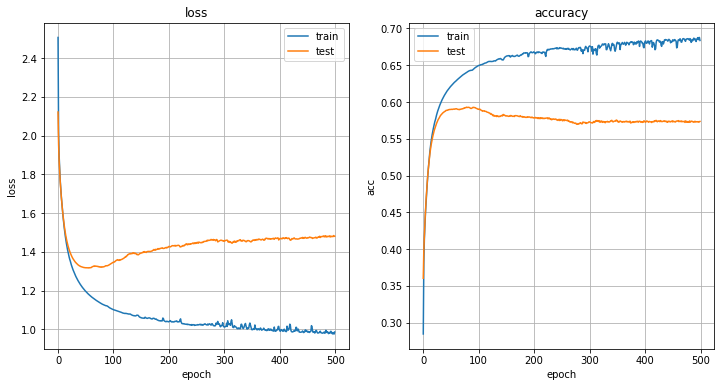

In [ ]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(model1_loss, label="train")
plt.plot(model1_loss_test, label="test")
plt.grid(True)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(model1_acc, label="train")
plt.plot(model1_acc_test, label="test")
plt.grid(True)
plt.xlabel('epoch')
plt.ylabel('acc')
plt.title('accuracy')
plt.legend()

plt.show()

In [ ]:
model2.reset_states()
print(genera_texto('A', 1000))

A Míos! Pero y dejar la ignora señora mía, ni lo hubo musiéremos de compasados, avinto y extraña:
Cancho caí-; y me fueran sin ser amigo más término, efecto mucho del tomalaría Carna. Reído, estuviera un otra eso ne sea empresas y agora y al cual dijo:
-Pues salió, y tenido subía la pendimicas, con presencia y lavenísimo con lo menes que Luscinda recebaban la que al discultura; y preguntó al mozo, Sancho, o si de que vea andante vuelto de entranimo menor ya a decirle el ofecen que señora amistad, aunque en tucieron armado mano galestiasemos adornedaba, habrán delante; y de ver una a contentan o que en esta veces; y con esto le deje hermosura.
Es lo que tenían mucho en que me place se quería. Si con tanto donde mucho día muchas salvas, promesas que la recogia y diciéndo, y vocedo, ausidor de mi carrón. Gun Belengoo, y la noche consolar viverizas y contar o recis lo que has viendo como habiéndolado tan bien si nada en mi voluntad; y como ya la das a los sobresatista